This notebook is used to model the frequency response we *should* expect to get from the species that were inside AZKABAN

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
from scipy import stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime

import inverse_method_funs_med as inv

In [66]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 11
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

one_col = 85 *0.0393701
two_col = 170*0.0393701

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figs/'

# Read results from scattering models
Scattering models for the copepods, krill and chaetognaths in the nets were run in ZooScatR, a package that runs PC-DWBA.

In [3]:
fname_sim = '../ZooScatStuff/AZKABAN_ZoopMix_data_FullBandwidth.feather'
simulations = pd.read_feather(fname_sim)
# Add a row for sigma_bs calculated from TS
simulations['sigbs'] = 10**(simulations.TS/10)

In [4]:
simulations

,TS,freq,L,la,g,h,orient,spec,sigbs
0,-131.975409,40.0,3.056419,5.756082,0.997545,1.031351,125.766106,Copepods,6.345401e-14
1,-131.763852,40.5,3.056419,5.756082,0.997545,1.031351,125.766106,Copepods,6.662156e-14
2,-131.554995,41.0,3.056419,5.756082,0.997545,1.031351,125.766106,Copepods,6.990375e-14
3,-131.348776,41.5,3.056419,5.756082,0.997545,1.031351,125.766106,Copepods,7.330311e-14
4,-131.145132,42.0,3.056419,5.756082,0.997545,1.031351,125.766106,Copepods,7.682221e-14
...,...,...,...,...,...,...,...,...,...
2747995,-91.490111,381.0,7.456714,2.278489,1.008832,1.017607,74.662372,Jellyfish,7.095596e-10
2747996,-91.485050,381.5,7.456714,2.278489,1.008832,1.017607,74.662372,Jellyfish,7.103869e-10
2747997,-91.478247,382.0,7.456714,2.278489,1.008832,1.017607,74.662372,Jellyfish,7.115006e-10
2747998,-91.469646,382.5,7.456714,2.278489,1.008832,1.017607,74.662372,Jellyfish,7.129112e-10


In [5]:
fname_copepod = '../ZooScatStuff/AZKABAN_ZoopMix_Copepodtests.feather'
simulations_c = pd.read_feather(fname_copepod)
simulations_c = simulations_c[simulations_c['spec']=='Copepods_Chu2005a']
# Add a row for sigma_bs calculated from TS
simulations_c['sigbs'] = 10**(simulations_c.TS/10)

In [6]:
simulations= simulations.append(simulations_c)

C:\Users\mbd\AppData\Local\Temp\ipykernel_94584\1786198826.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  simulations= simulations.append(simulations_c)


In [7]:
specs = simulations.spec.unique()
freqs = simulations.freq.unique()

# Calculate ci

In [8]:
# Calculates 50% confidence interval
def ci0(x):
    return  st.t.interval(0.5, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[0]
def ci1(x):
    return  st.t.interval(0.5, len(x) - 1, scale=st.sem(x, nan_policy='omit'))[1]

ci_0 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0})
ci_1 = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1})

In [9]:
ci_0

sigbs
spec         freq               
Chaetognaths 40.0  -3.551051e-11
             40.5  -3.668724e-11
             41.0  -3.789354e-11
             41.5  -3.912879e-11
             42.0  -4.042318e-11
...                          ...
Jellyfish    381.0 -2.711809e-09
             381.5 -2.777891e-09
             382.0 -2.841630e-09
             382.5 -2.902404e-09
             383.0 -2.959610e-09

[3435 rows x 1 columns]

NameError: name 'axis_font' is not defined

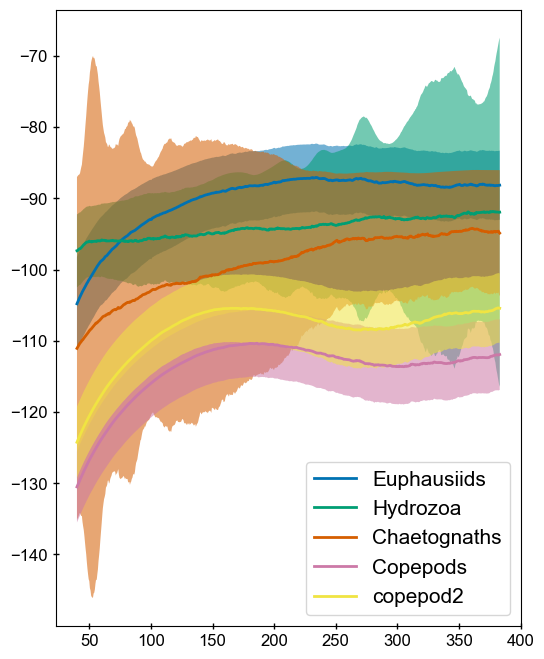

In [10]:
# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(figsize=(6, 8),facecolor='w', edgecolor='k')
order = [1,3,2,0,4]
label_name=['Copepods', 'Euphausiids', 'Chaetognaths', 'Hydrozoa', 'copepod2']
for ind in order:

    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[ind]]['sigbs'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))
    
    plt.plot(freqs,10*np.log10(median_select), linewidth=2, label=label_name[ind])
    plt.fill_between(freqs,logci_0, logci_1, alpha=0.55)
    
#plt.legend(fontsize=15, loc=(0.40,0.25))
plt.legend(fontsize=15, loc='lower right')
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.axvline(x=200, linestyle='--', c='grey')
plt.xlim([40,383])
#plt.xlim([185,255])
plt.ylim([-135,-70])
#plt.title('Scattering model results', title_font);

ax.set_rasterized(True)
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/AZKABAN_modeledspectra.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
#fig.savefig(savefigjpg_path+'Figure6.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [11]:
# Print mean TS
for spec_ind in range(len(specs)):
    TS_mean = 10*np.log10(np.mean(median_bs[median_bs.index==specs[spec_ind]].sigbs))
    print(f'Mean TS for {specs[spec_ind]} is {TS_mean:.2f} dB re 1m^2.')

Mean TS for Copepods is -112.85 dB re 1m^2.
Mean TS for Euphausiids is -88.99 dB re 1m^2.
Mean TS for Chaetognaths is -97.61 dB re 1m^2.
Mean TS for Jellyfish is -93.90 dB re 1m^2.
Mean TS for Copepods_Chu2005a is -107.42 dB re 1m^2.


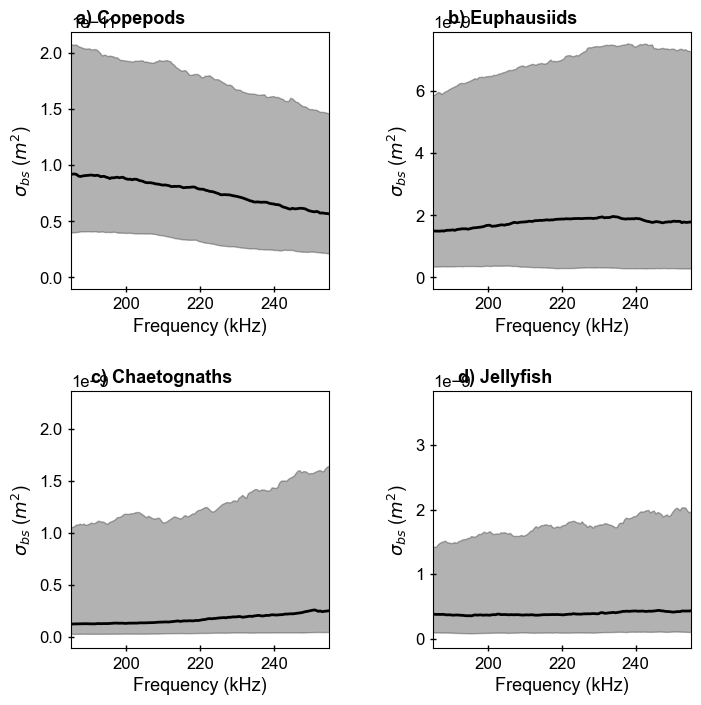

In [12]:
def ci0_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.50, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[1]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})

ci_0_linear = simulations.groupby(["spec","freq"]).quantile(q=0.25)
ci_1_linear = simulations.groupby(["spec","freq"]).quantile(q=0.75)


# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')

fig, ax = plt.subplots(2,2, figsize=(8, 8),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.4, wspace=0.4)
axes = ax.flatten()
order = [0,1,2,3]

letter = [' a) Copepods','   b) Euphausiids', '    c) Chaetognaths', '     d) Jellyfish']
for i in range(4):
    ind = order[i]
    median_select = median_bs.loc[specs[ind]]['sigbs'].to_numpy()
    ci_0_select = ci_0_linear.loc[specs[ind]]['sigbs'].to_numpy()
    ci_1_select = ci_1_linear.loc[specs[ind]]['sigbs'].to_numpy()


    
    axes[i].plot(freqs,median_select, color='black', linewidth=2)#, color=sns.color_palette()[i])
    axes[i].fill_between(freqs,ci_0_select, ci_1_select, color='black', alpha=0.3)#, color=sns.color_palette()[i])
    
    axes[i].set_title(letter[i], fontsize=BIGGER_SIZE, fontweight='bold', loc='left')
    axes[i].set_ylabel('$\sigma_{bs}$ ($m^{2}$)')
    axes[i].set_xlabel('Frequency (kHz)')
    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[i].set_xlim([185,255])
    axes[i].set_rasterized(True)
    
#axes[0].set_ylim([4e-12,9.5e-12])
#axes[1].set_ylim([1.6e-9,2.1e-9])    
#axes[2].set_ylim([0,3.5e-10])
#axes[3].set_ylim([-0.5e-9,1.5e-9])


#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-light/ZoopMix_paper/Figure5linear.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [13]:
ci_0_linear

TS          L         la         g         h  \
spec         freq                                                          
Chaetognaths 40.0  -117.266178  13.682209  20.719862  1.026560  1.026457   
             40.5  -117.164021  13.682209  20.719862  1.026560  1.026457   
             41.0  -117.090961  13.682209  20.719862  1.026560  1.026457   
             41.5  -116.891625  13.682209  20.719862  1.026560  1.026457   
             42.0  -116.727136  13.682209  20.719862  1.026560  1.026457   
...                        ...        ...        ...       ...       ...   
Jellyfish    381.0  -99.304413   8.146692   2.466207  1.003704  1.003666   
             381.5  -99.312329   8.146692   2.466207  1.003704  1.003666   
             382.0  -99.394867   8.146692   2.466207  1.003704  1.003666   
             382.5  -99.437664   8.146692   2.466207  1.003704  1.003666   
             383.0  -99.370669   8.146692   2.466207  1.003704  1.003666   

                       orient         sigbs  
spec         freq                            
Chaetognaths 40.0  -19.596457  1.876758e-12  
             40.5  -19.596457  1.921313e-12  
             41.0  -19.596457  1.953909e-12  
             41.5  -19.596457  2.045696e-12  
             42.0  -19.596457  2.124662e-12  
...                       ...           ...  
Jellyfish    381.0  68.591528  1.173706e-10  
             381.5  68.591528  1.171570e-10  
             382.0  68.591528  1.149514e-10  
             382.5  68.591528  1.138240e-10  
             383.0  68.591528  1.155965e-10  

[3435 rows x 7 columns]

In [14]:
np.e**0.5

1.6487212707001282

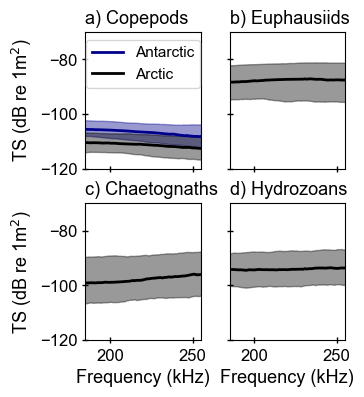

In [15]:
def ci0_linear(x):
    return  st.t.interval(0.5, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.5, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})
ci_0_linear = simulations.groupby(["spec","freq"]).quantile(q=0.25) # 25th and 75th quantile for 50% confidence interval.
ci_1_linear = simulations.groupby(["spec","freq"]).quantile(q=0.75)

# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')



fig, ax = plt.subplots(2,2, figsize=(one_col, 4),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.25, wspace=0.25)
axes = ax.flatten()
order = [4,0,1,2,3]
label_name=['Arctic', 'Euphausiids', 'Chaetognaths', 'Hydrozoa', 'Antarctic']
letter = ['a) Copepods','b) Euphausiids', 'c) Chaetognaths', 'd) Hydrozoans']
for i in order:
    ind=i
    c='black'
    a2=0.4
    
    if i==4:
        ind=0
        c='darkblue'
        a1=0.1
        
    median_select = median_bs.loc[specs[i]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[i]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[i]]['sigbs'].to_numpy()
    ci_0_select = ci_0_linear.loc[specs[i]]['TS'].to_numpy()
    ci_1_select = ci_1_linear.loc[specs[i]]['TS'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    #logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    #logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))

    
    axes[ind].plot(freqs,10*np.log10(median_select), color=c, linewidth=2, label=label_name[i])
    axes[ind].fill_between(freqs,ci_0_select, ci_1_select, color=c, alpha=a2)
    axes[ind].set_title(letter[ind], fontsize=BIGGER_SIZE, loc='left')


    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[ind].set_xlim([185,255])
    axes[ind].set_rasterized(True)
    #axes[i].set_xlim([40,383])
    axes[ind].set_ylim([-120,-70])

axes[0].legend(fontsize=11, loc='upper center')

axes[0].set_ylabel('TS (dB re 1m$^{2}$)')
axes[2].set_ylabel('TS (dB re 1m$^{2}$)')

axes[2].set_xlabel('Frequency (kHz)',)
axes[3].set_xlabel('Frequency (kHz)')

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[3].set_yticklabels([])
#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigs_path +'Figure5_model.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

# Spaghetti

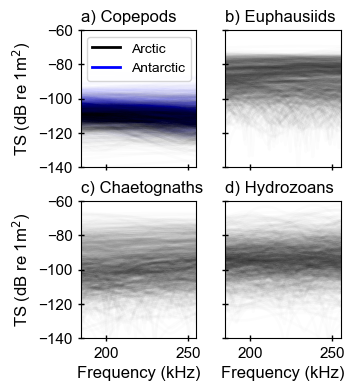

In [124]:
fig, ax = plt.subplots(2,2, figsize=(one_col, 4),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.25, wspace=0.25)
axes = ax.flatten()
order = [4,0,1,2,3]
label_name=['Arctic', 'Euphausiids', 'Chaetognaths', 'Hydrozoa', 'Antarctic']
letter = ['a) Copepods','b) Euphausiids', 'c) Chaetognaths', 'd) Hydrozoans']
for i in order:
    ind=i
    c='black'
    a1=0.01
    
    if i==4:
        ind=0
        c='blue'
        a1=0.006
        
    sim_TS = simulations[simulations['spec']==specs[i]].TS.to_numpy()
    TS = sim_TS.reshape((1000,len(freqs)))
    
    line = axes[ind].plot(freqs,TS.T, color=c, linewidth=2, alpha=a1)
    axes[ind].set_title(letter[ind], fontsize=BIGGER_SIZE, loc='left')


    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[ind].set_xlim([185,255])
    axes[ind].set_rasterized(True)
    #axes[i].set_xlim([40,383])
    axes[ind].set_ylim([-140,-60])
    
    if i==0:
        handle1 = line[0]
        
    if i==4:
        handle2 = line[0]
            
leg = axes[0].legend([handle1, handle2], ['Arctic', 'Antarctic'], fontsize=10, loc='upper center')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

axes[0].set_ylabel('TS (dB re 1m$^{2}$)')
axes[2].set_ylabel('TS (dB re 1m$^{2}$)')

axes[2].set_xlabel('Frequency (kHz)',)
axes[3].set_xlabel('Frequency (kHz)')

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[3].set_yticklabels([])
#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigs_path +'Figure5_model_spaghetti.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

Text(0.5, 0, 'Frequency (kHz)')

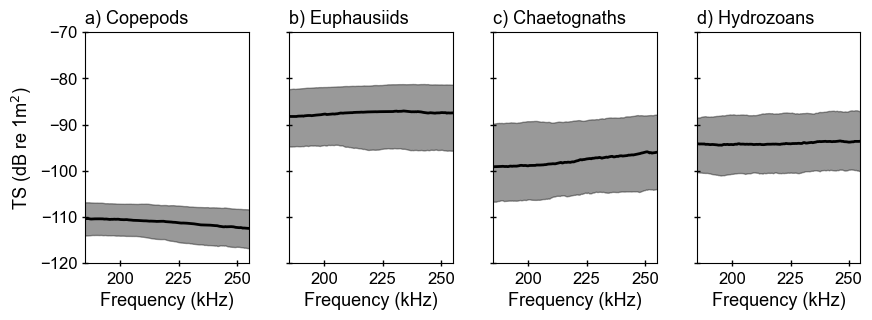

In [16]:
def ci0_linear(x):
    return  st.t.interval(0.5, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]
def ci1_linear(x):
    return  st.t.interval(0.5, len(x) - 1, loc=np.nanmedian(x), scale=st.sem(x, nan_policy='omit'))[0]

ci_0_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci0_linear})
ci_1_linear = simulations.groupby(["spec","freq"]).agg({'sigbs': ci1_linear})
ci_0_linear = simulations.groupby(["spec","freq"]).quantile(q=0.25) # 25th and 75th quantile for 50% confidence interval.
ci_1_linear = simulations.groupby(["spec","freq"]).quantile(q=0.75)

# Convert to log confidence intervals
simulations_median = simulations.groupby(["spec","freq"]).agg({'sigbs':'median'})
median_bs = simulations_median.reset_index('freq')



fig, ax = plt.subplots(1,4, figsize=(10, 3),facecolor='w', edgecolor='k',sharex=True, sharey=True)
fig.subplots_adjust(hspace=.25, wspace=0.25)
axes = ax.flatten()
order = [0,1,2,3]
label_name=['Arctic', 'Euphausiids', 'Chaetognaths', 'Hydrozoa', 'Antarctic']
letter = ['a) Copepods','b) Euphausiids', 'c) Chaetognaths', 'd) Hydrozoans']
for i in order:
    ind=i
    c='black'
    a2=0.4
    
    if i==4:
        ind=0
        c='darkblue'
        a1=0.1
        
    median_select = median_bs.loc[specs[i]]['sigbs'].to_numpy()
    ci_0_select = ci_0.loc[specs[i]]['sigbs'].to_numpy()
    ci_1_select = ci_1.loc[specs[i]]['sigbs'].to_numpy()
    ci_0_select = ci_0_linear.loc[specs[i]]['TS'].to_numpy()
    ci_1_select = ci_1_linear.loc[specs[i]]['TS'].to_numpy()
    
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    #logci_0 = 10*np.log10(median_select) - (10*(0.434*(median_select-ci_0_select)/median_select))
    #logci_1 = 10*np.log10(median_select) + (10*(0.434*(median_select+ci_1_select)/median_select))

    
    axes[ind].plot(freqs,10*np.log10(median_select), color=c, linewidth=2)
    axes[ind].fill_between(freqs,ci_0_select, ci_1_select, color=c, alpha=a2)
    axes[ind].set_title(letter[ind], fontsize=BIGGER_SIZE, loc='left')


    #plt.axvline(x=200, linestyle='--', c='grey')
    axes[ind].set_xlim([185,255])
    axes[ind].set_rasterized(True)
    #axes[i].set_xlim([40,383])
    axes[ind].set_ylim([-120,-70])


axes[0].set_ylabel('TS (dB re 1m$^{2}$)')
#axes[2].set_ylabel('TS (dB re 1m$^{2}$)')
axes[0].set_xlabel('Frequency (kHz)')
axes[1].set_xlabel('Frequency (kHz)')
axes[2].set_xlabel('Frequency (kHz)')
axes[3].set_xlabel('Frequency (kHz)')

#axes[0].set_xticklabels([]);
#axes[1].set_xticklabels([])
#axes[1].set_yticklabels([])
#axes[3].set_yticklabels([])
#plt.title('Scattering model results', title_font);


#fig.savefig(savefigs_path+'Figure6.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
#fig.savefig('C:\Users\mbd\OneDrive - Akvaplan-niva AS\PhD-APN\PhDdocs\ConferencesMeetings\WGFAST2023\Figure5_scattering.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [17]:
specs

array(['Copepods', 'Euphausiids', 'Chaetognaths', 'Jellyfish',
       'Copepods_Chu2005a'], dtype=object)

# Plot length distributions

In [18]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# For gamma distirbution scale = 1/rate. alpha = shape.
# For log normal distribution. s=sigma(logstd), scale=e^(mu or logmean)

# Length distribution was calculated using all measured lengths (divided by 2!)
x=np.arange(0,35,0.01)
euphausiid_dist = stats.lognorm.pdf(x, s=0.3,scale=np.exp(2.4))
jelly_dist = stats.lognorm.pdf(x, s=0.4, scale=np.exp(2.4))
chaetognaths_dist = stats.gamma.pdf(x, a=10.6, scale=1/0.6)
copepod_dist = stats.norm.pdf(x, loc=3.3, scale = 0.7)

NameError: name 'axis_font' is not defined

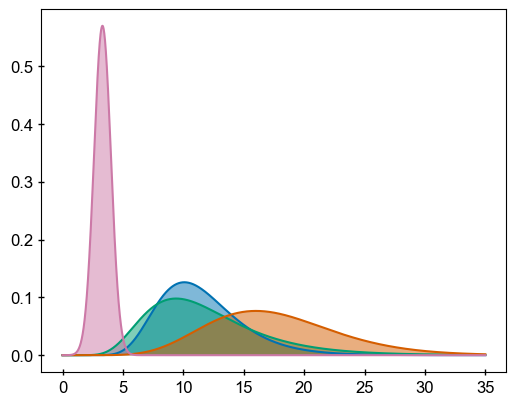

In [19]:
plt.figure(figsize=(6,16))
ax = plt.subplot(3,1,1)
plt.plot(x, euphausiid_dist)
plt.fill_between(x, euphausiid_dist, alpha=0.5, label='Euphausiids')
plt.plot(x, jelly_dist)
plt.fill_between(x, jelly_dist, alpha=0.5, label='Hydrozoa')
plt.plot(x, chaetognaths_dist)
plt.fill_between(x, chaetognaths_dist, alpha=0.5, label='Chaetognaths')
plt.plot(x, copepod_dist)
plt.fill_between(x, copepod_dist, alpha=0.5, label='Copepods')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=15)


In [ ]:
Euphausiid_mean = stats.lognorm.median(s=0.3,scale=np.exp(2.4))
Euphausiid_std = stats.lognorm.std(s=0.3,scale=np.exp(2.4))
print(f'Mean length of euphausiids is {Euphausiid_mean: .2f} $\pm {Euphausiid_std: .2f} mm')

In [ ]:
Jelly_mean = stats.lognorm.median(s=0.4,scale=np.exp(2.4))
Jelly_std = stats.lognorm.std(s=0.4,scale=np.exp(2.4))
print(f' Mean length of hydrozoa is {Jelly_mean: .2f} \pm {Jelly_std: .2f} mm')

In [ ]:
Chaeto_mean = stats.gamma.median(a=10.6, scale=1/0.6)
Chaeto_std= stats.gamma.std(a=10.6, scale=1/0.6)
print(f'Mean length of chaetognaths {Chaeto_mean: .2f} \pm {Chaeto_std: .2f} mm')

In [ ]:
sns.histplot(data=simulations, x='L', hue='spec', stat='density')